<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 758, done.
remote: Total 758 (delta 0), reused 0 (delta 0), pack-reused 758
Receiving objects: 100% (758/758), 118.40 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Updating files: 100% (129/129), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16619 sha256=97857656e6f6bcdb936cc32fd7ff3c8bb775957e69f9a545d73b5b0e5bf67b6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-08o1u070/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul


In [ ]:
from deepul.hw2_helper import *
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import deepul.pytorch_util as ptu
import deepul.pytorch_util as ptu
from tqdm import trange, tqdm_notebook
import matplotlib.pyplot as plt
import time

ptu.set_gpu_mode(False)

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data.

Execute the cell below to visualize our datasets

Dataset 1


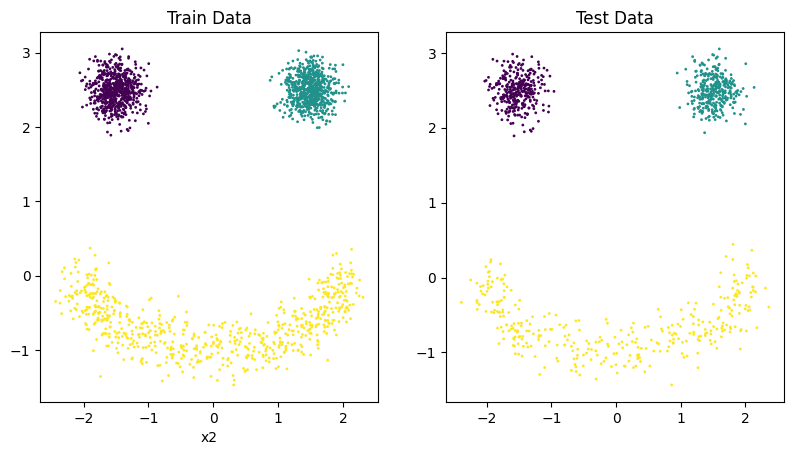

Dataset 2


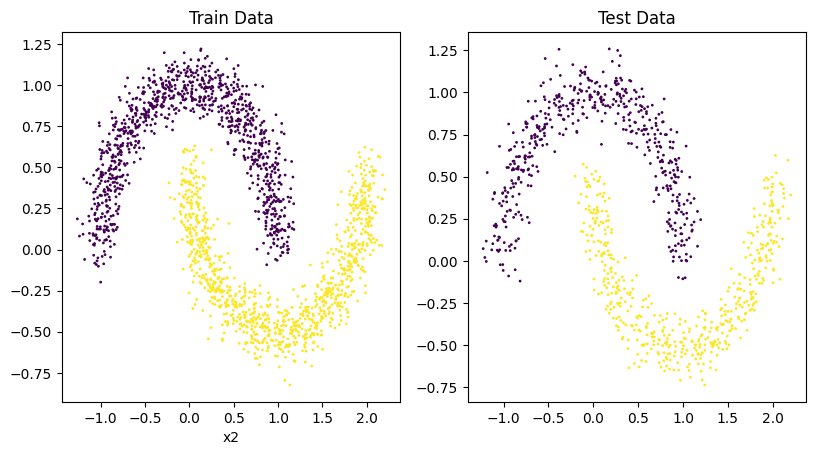

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def train(model, train_loader, optimizer, device):
  model.train()
  loss_values = []
  for x in train_loader:
    x = x.float().to(device) .contiguous()
    z, loss, _ = model(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
  return loss_values

def eval_loss(model, data_loader, device):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.float().to(device).contiguous()
      z, loss, _ = model(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)
  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, epochs, lr, device):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_loss_values = []
  test_loss_values = []
  test_loss = eval_loss(model, test_loader, device)
  test_loss_values.append(test_loss)
  for epoch in range(epochs):
    model.train()
    epochs_train_loss_values = train(model, train_loader, optimizer, device)
    train_loss_values.extend(epochs_train_loss_values)

    test_loss = eval_loss(model, test_loader, device)
    test_loss_values.append(test_loss)

    if epoch%10==0:
      print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss_values[-1]}, Test Loss: {test_loss_values[-1]}')

  return train_loss_values, test_loss_values

In [ ]:
# model
class Autoregressive_Flow(nn.Module):
  def __init__(self,
               device,
               mixture_dist = 'gaussian',
               n_components = 5,
               base_dist = 'uniform'):
    assert mixture_dist == 'gaussian'
    assert base_dist == 'uniform'
    super().__init__()
    self.mixture_dist = mixture_dist
    self.base_dist = base_dist
    self.hidden_size = 64
    self.lstm = nn.LSTM(input_size = 1, hidden_size = self.hidden_size, batch_first = True)
    self.mlp = nn.Sequential(nn.Linear(self.hidden_size, 32),
                              nn.ReLU(),
                              nn.Linear(32, 3*n_components))
    self.device = device

  def forward(self, x):
    batch = x.shape[0]
    x = x.float().view(batch, -1, 1) # batch, length, 1   (length = dimensions of data = 2)

    seq = torch.cat((torch.zeros(batch, 1, 1).to(self.device), x[:, :-1, :]), dim=1) # batch, length, 1
    seq, _ = self.lstm(seq) # batch, length, hidden_size
    seq = self.mlp(seq) # batch, length, 3*n_components
    if self.mixture_dist == 'gaussian':
      mu, log_scale, weight, = torch.chunk(seq, 3, dim=-1) # mu(log_scale, weight): batch, length, n_components
      weight = F.softmax(weight, dim=-1)
      z = (torch.distributions.Normal(mu, log_scale.exp()).cdf(x) * weight).sum(dim=-1) # batch, length
      log_jac = (torch.distributions.Normal(mu, log_scale.exp()).log_prob(x).exp() * weight).sum(dim=-1).log() # batch, length

    log_prob = (torch.distributions.Uniform(0, 1, validate_args=False).log_prob(z) + log_jac).mean(dim=-1)
    nll = - log_prob.mean()
    return z, nll, log_prob

In [ ]:
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity).
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents
      mapping the train set data points through our flow to the latent space.
  """

  """ YOUR CODE HERE """
  # create data loaders
  loader_args = dict(batch_size=128, shuffle=True)
  train_loader = data.DataLoader(train_data, **loader_args)
  test_loader = data.DataLoader(test_data, **loader_args)

  device = ptu.device
  # model
  model = Autoregressive_Flow(device = device)


  # train
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=100, lr=5e-3, device=device)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  _, _, log_prob = model(mesh_xs)
  densities = np.exp(ptu.get_numpy(log_prob))

  # latents
  z, _, _ = model(ptu.FloatTensor(train_data))
  latents = ptu.get_numpy(z)

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch: 0/100, Train Loss: 1.9554919004440308, Test Loss: 1.95730459690094
Epoch: 10/100, Train Loss: 1.2056913375854492, Test Loss: 1.1819814443588257
Epoch: 20/100, Train Loss: 1.1933337450027466, Test Loss: 1.1465293169021606
Epoch: 30/100, Train Loss: 1.0831637382507324, Test Loss: 1.1202645301818848
Epoch: 40/100, Train Loss: 1.1946948766708374, Test Loss: 1.1250205039978027
Epoch: 50/100, Train Loss: 1.2716796398162842, Test Loss: 1.1053850650787354
Epoch: 60/100, Train Loss: 0.7842085361480713, Test Loss: 0.7896491885185242
Epoch: 70/100, Train Loss: 0.6461003422737122, Test Loss: 0.7403422594070435
Epoch: 80/100, Train Loss: 0.6119741201400757, Test Loss: 0.7066119313240051
Epoch: 90/100, Train Loss: 0.6478543877601624, Test Loss: 0.7019969820976257
Final Test Loss: 0.6965


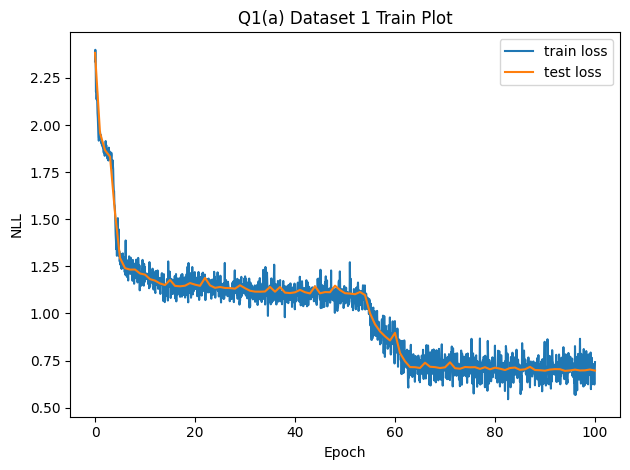

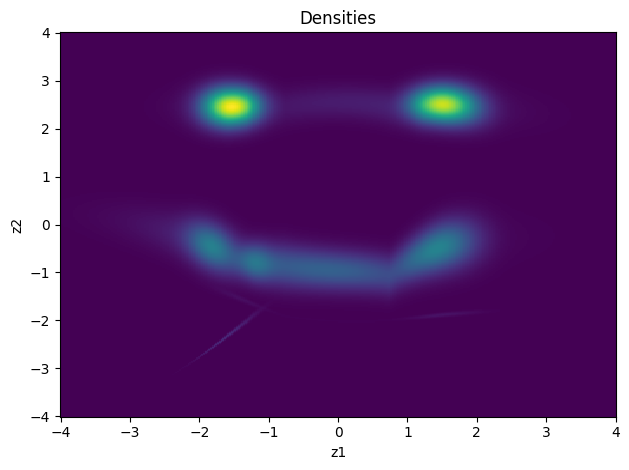

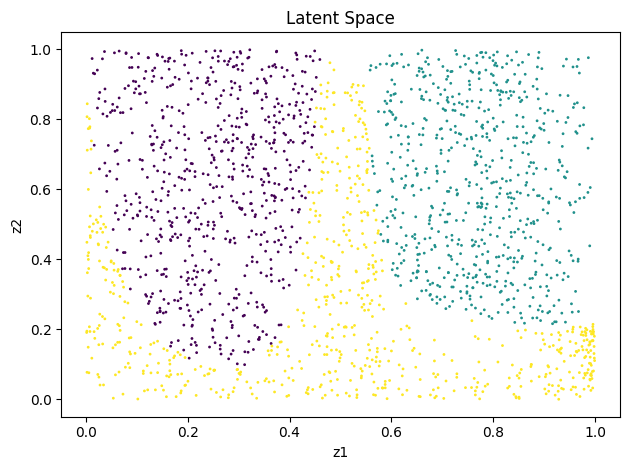

In [ ]:
q1_save_results(1, 'a', q1_a)

Epoch: 0/100, Train Loss: 1.1135876178741455, Test Loss: 1.0778130292892456
Epoch: 10/100, Train Loss: 0.724078893661499, Test Loss: 0.7573233842849731
Epoch: 20/100, Train Loss: 0.7420552968978882, Test Loss: 0.6530960202217102
Epoch: 30/100, Train Loss: 0.6580012440681458, Test Loss: 0.6213139891624451
Epoch: 40/100, Train Loss: 0.6633156538009644, Test Loss: 0.6147100925445557
Epoch: 50/100, Train Loss: 0.6421489119529724, Test Loss: 0.623328685760498
Epoch: 60/100, Train Loss: 0.6230088472366333, Test Loss: 0.6045450568199158
Epoch: 70/100, Train Loss: 0.5870687961578369, Test Loss: 0.5869070291519165
Epoch: 80/100, Train Loss: 0.5925270318984985, Test Loss: 0.5938109159469604
Epoch: 90/100, Train Loss: 0.6029096245765686, Test Loss: 0.5689823031425476
Final Test Loss: 0.5830


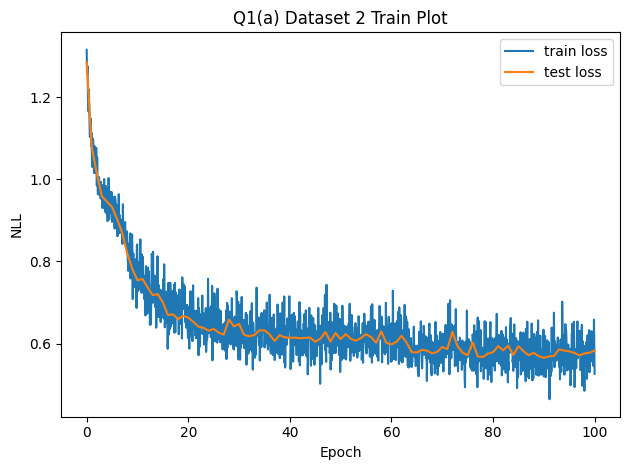

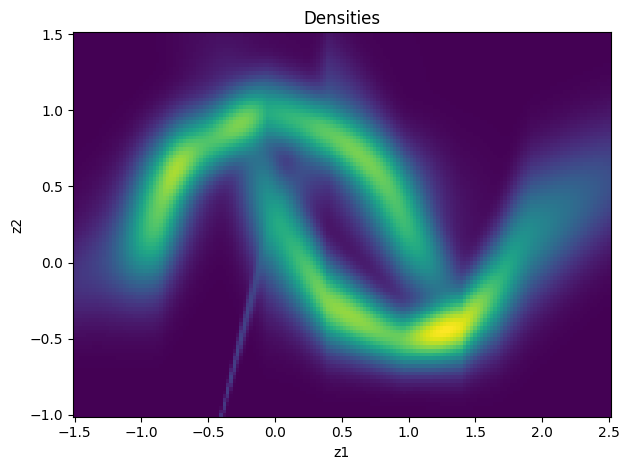

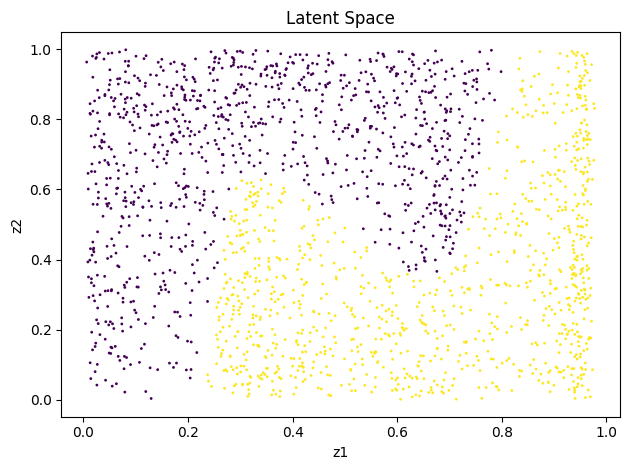

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure:
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$,
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# model
class AffineTransformation(nn.Module):
  def __init__(self, mask_type, device):
    super().__init__()
    self.a = nn.Parameter(torch.rand(1))
    self.b = nn.Parameter(torch.rand(1))
    self.mlp_scale = nn.Sequential(nn.Linear(2, 64),
                             nn.ReLU(),
                             nn.Linear(64, 64),
                             nn.ReLU(),
                             nn.Linear(64, 2))

    self.mlp_shift = nn.Sequential(nn.Linear(2, 64),
                             nn.ReLU(),
                             nn.Linear(64, 64),
                             nn.ReLU(),
                             nn.Linear(64, 2))

    self.mask = self.create_mask(mask_type, device)

  def create_mask(self, mask_type, device):
    assert mask_type in ['left', 'right']
    if mask_type == 'left':
      return torch.Tensor([1, 0]).to(device)
    else:
      return torch.Tensor([0, 1]).to(device)

  def forward(self, x, inverse=False):
    shift = self.mlp_shift(x*(1-self.mask))*self.mask   # batch, 2
    log_scale = (self.a * torch.tanh(self.mlp_scale(x*(1-self.mask))) + self.b)*self.mask   # batch, 2
    if inverse==False:
      x = torch.exp(log_scale) * x*self.mask + shift + (1 - self.mask)*x    # batch, 2
      log_det = log_scale.sum(dim=-1)   # batch,
      return x, log_det
    else:
      x = torch.exp(-log_scale)*(x*self.mask - shift) + (1 - self.mask)*x
      return x


class RealNVP(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.stack = nn.ModuleList([AffineTransformation(mask_type='left', device=device),
                                AffineTransformation(mask_type='right', device=device),
                                AffineTransformation(mask_type='left', device=device),
                                AffineTransformation(mask_type='right', device=device),
                                AffineTransformation(mask_type='left', device=device),
                                AffineTransformation(mask_type='right', device=device),
                                AffineTransformation(mask_type='left', device=device)])

  def forward(self, x, inverse=False):
    if inverse==False:
      sum_log_det = 0
      for layer in self.stack:
        x, log_det = layer(x)
        sum_log_det += log_det

      # print(torch.distributions.Normal(0., 1.).log_prob(x).sum(dim=-1).shape)
      # print(sum_log_det.shape)
      log_prob = torch.distributions.Normal(0., 1.).log_prob(x).sum(dim=-1) + sum_log_det
      nll = - log_prob.mean()
      return x, nll, log_prob

    else:
      for layer in reversed(self.stack):
        x = layer.forward(x, inverse=True)
      return x

In [ ]:
def q1_b(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity).
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in R^2. This represents
      mapping the train set data points through our flow to the latent space.
  """

  """ YOUR CODE HERE """
  device = ptu.device

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)

  model = RealNVP(device)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=250, lr=2e-3, device=device)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  _, _, log_prob = model.forward(mesh_xs)
  densities = np.exp(ptu.get_numpy(log_prob))

  # latents
  z, _, _ = model.forward(ptu.FloatTensor(train_data))
  latents = ptu.get_numpy(z)

  return train_losses, test_losses, densities, latents


### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch: 0/250, Train Loss: 10.419550895690918, Test Loss: 9.704561233520508
Epoch: 10/250, Train Loss: 2.3758397102355957, Test Loss: 2.165534257888794
Epoch: 20/250, Train Loss: 1.7720348834991455, Test Loss: 1.840888500213623
Epoch: 30/250, Train Loss: 1.5557459592819214, Test Loss: 1.652726173400879
Epoch: 40/250, Train Loss: 1.5871574878692627, Test Loss: 1.5308464765548706
Epoch: 50/250, Train Loss: 1.5139033794403076, Test Loss: 1.5618444681167603
Epoch: 60/250, Train Loss: 1.7289553880691528, Test Loss: 1.5150957107543945
Epoch: 70/250, Train Loss: 1.356372594833374, Test Loss: 1.4846724271774292
Epoch: 80/250, Train Loss: 1.6016597747802734, Test Loss: 1.4314688444137573
Epoch: 90/250, Train Loss: 1.5010781288146973, Test Loss: 1.5017544031143188
Epoch: 100/250, Train Loss: 1.4435449838638306, Test Loss: 1.4878413677215576
Epoch: 110/250, Train Loss: 1.484031081199646, Test Loss: 1.4954320192337036
Epoch: 120/250, Train Loss: 1.6215553283691406, Test Loss: 1.4872194528579712
Epo

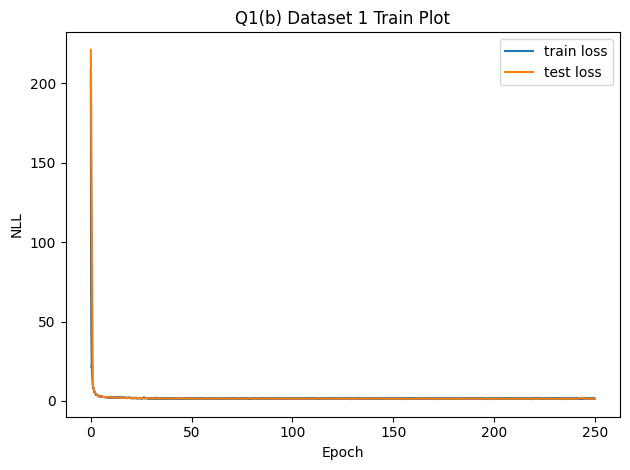

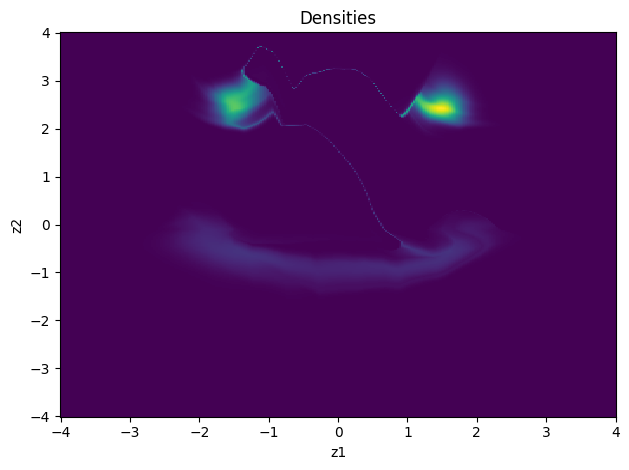

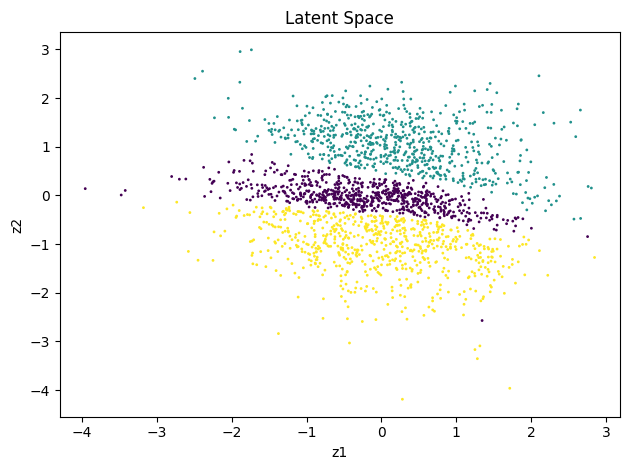

In [ ]:
q1_save_results(1, 'b', q1_b)

Epoch: 0/250, Train Loss: 4.830509662628174, Test Loss: 4.165253162384033
Epoch: 10/250, Train Loss: 1.6453711986541748, Test Loss: 1.6493772268295288
Epoch: 20/250, Train Loss: 1.3758337497711182, Test Loss: 1.3834190368652344
Epoch: 30/250, Train Loss: 1.1783201694488525, Test Loss: 1.214296579360962
Epoch: 40/250, Train Loss: 1.2601745128631592, Test Loss: 1.13286292552948
Epoch: 50/250, Train Loss: 1.130100131034851, Test Loss: 1.1455668210983276
Epoch: 60/250, Train Loss: 1.2272101640701294, Test Loss: 1.0634428262710571
Epoch: 70/250, Train Loss: 1.23439621925354, Test Loss: 1.098374605178833
Epoch: 80/250, Train Loss: 1.0771534442901611, Test Loss: 1.0683268308639526
Epoch: 90/250, Train Loss: 0.9765297770500183, Test Loss: 1.021864414215088
Epoch: 100/250, Train Loss: 0.9224664568901062, Test Loss: 1.0490989685058594
Epoch: 110/250, Train Loss: 1.1439049243927002, Test Loss: 1.0794179439544678
Epoch: 120/250, Train Loss: 1.1759250164031982, Test Loss: 1.0271079540252686
Epoch: 

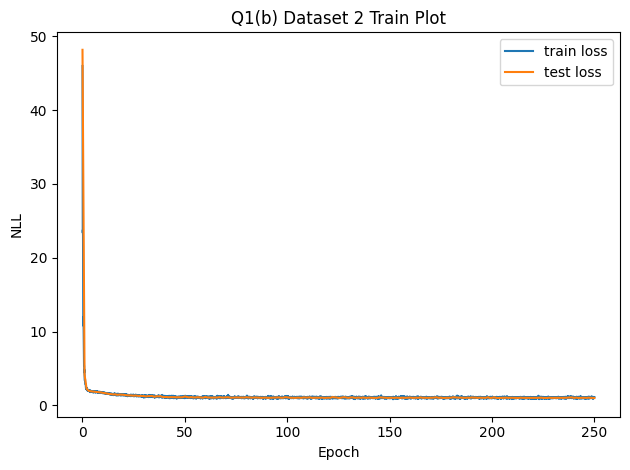

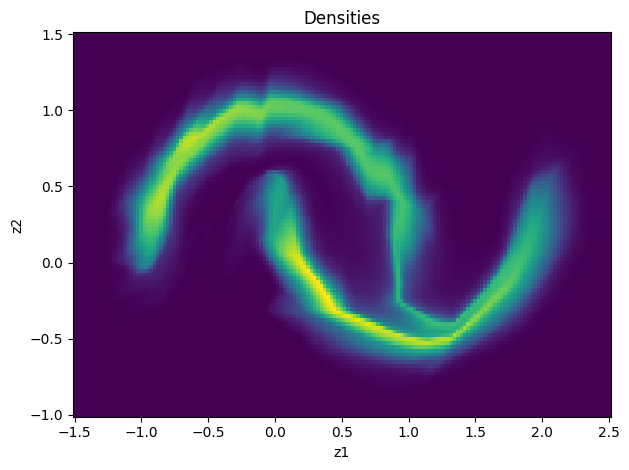

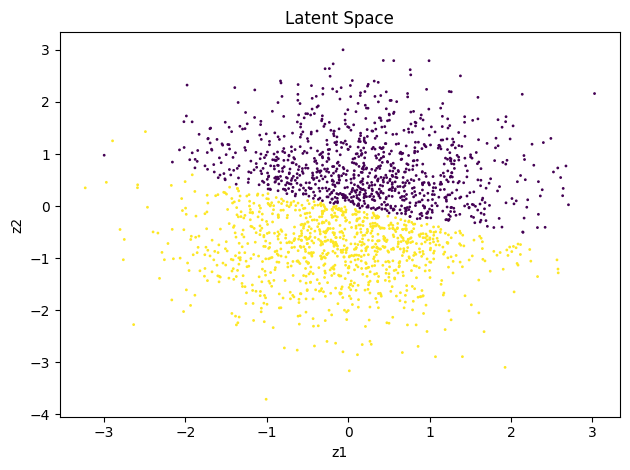

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

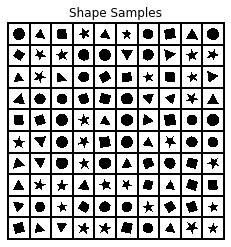

In [ ]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x.

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training.

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization).


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# model
class LayerNorm(nn.LayerNorm):
  def __init__(self, *args, **kwargs):
    super().__init()

  def forward(self, x):
    x = x.permute(0, 2, 3, 1)
    x = super().forward(x)
    x = x.contiguous().permute(0, 3, 1, 2)
    return x


class MaskedConv2d(nn.Conv2d):
  def __init__(self, device, mask_type, *args, **kwargs):
    assert mask_type in ['A', 'B']
    super().__init__(*args, **kwargs)
    self.device = device
    self.mask = self.register_buffer('mask', torch.zeros_like(self.weight))
    self.mask = self.create_mask(mask_type)

  def create_mask(self, mask_type):
    mask = torch.zeros_like(self.weight).to(self.device)
    mask[:, :, :self.kernel_size[0]//2, :] = 1
    mask[:, :, self.kernel_size[0]//2, :self.kernel_size[1]//2] = 1
    if mask_type == 'B':
      mask[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 1
    return mask

  def forward(self, x):
    return F.conv2d(x, self.mask*self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class AFPixelCNN(nn.Module):
  def __init__(self, input_size, n_components, device):
    super().__init__()
    self.input_size = input_size
    self.device = device
    self.n_components = n_components
    self.net = nn.Sequential(MaskedConv2d(device, 'A', self.input_size[0], 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 64, 7, padding=3),
                             nn.ReLU(),
                             MaskedConv2d(device, 'B', 64, 3*n_components*self.input_size[0], 7, padding=3))

  def forward(self, x):
    batch = x.shape[0]
    mean, log_scale, weight_logits = torch.chunk(self.net(x).reshape(batch, 3*self.n_components, *self.input_size), 3, dim=1)
    # mean, log_scale, weight_logit  [batch, n_component, channels, height, width]
    weights = F.softmax(weight_logits, dim=1)
    scale = log_scale.exp()
    jacobian = (torch.distributions.Normal(mean, scale).log_prob(x.unsqueeze(1)).exp() * weights).sum(dim=1) # batch, channels, height, width
    log_jac = jacobian.log()
    # print(log_jac)
    z = (torch.distributions.Normal(mean, scale).cdf(x.unsqueeze(1))*weights).sum(dim=1) # batch, channels, height, width

    log_prob = log_jac.mean(dim=[1, 2, 3]) # batch
    nll = -log_prob.mean()
    # print(nll)

    return z, nll, log_prob


  def sample(self, n):
    samples = torch.zeros(n, *self.input_size).to(self.device)
    with torch.no_grad():
      for c in range(self.input_size[0]):
        for i in range(self.input_size[1]):
          for j in range(self.input_size[2]):
            mean, log_scale, weight_logits = torch.chunk(self.net(samples).view(n, 3*self.n_components, *self.input_size), 3, dim=1)
            mean = mean[:, :, c, i, j]
            log_scale = log_scale[:, :, c, i, j]
            weights = F.softmax(weight_logits[:, :, c, i, j], dim=1)
            centers = torch.multinomial(weights, num_samples=1).squeeze() # [n]
            mean = mean[np.arange(n), centers].squeeze() # [n]
            log_scale = log_scale[np.arange(n), centers].squeeze()  # [n]
            samples[:, c, i ,j] = torch.normal(mean, log_scale.exp())
      return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def q2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise.
  """

  """ YOUR CODE HERE """
  # device = ptu.device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  test_data = test_data  +  np.random.uniform(low =0.0, high=1.0, size=test_data.shape)
  train_data = np.transpose(train_data, axes=(0, 3, 1, 2))/2.0
  test_data = test_data  +  np.random.uniform(low =0.0, high=1.0, size=test_data.shape)
  test_data = np.transpose(test_data, axes=(0, 3, 1, 2))/2.0

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)

  model = AFPixelCNN((1, 20, 20), 10, device).to(device)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, epochs=20, lr=1e-3, device=device)
  samples = model.sample(100)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



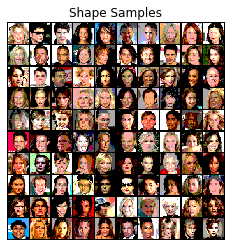

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer.



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs.



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images.



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# model
class ResnetBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.stack = nn.Sequential(nn.Conv2d(channels, channels, (1, 1), stride=1, padding=0),
                               nn.ReLU(),
                               nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1),
                               nn.ReLU(),
                               nn.Conv2d(channels, channels, (1, 1), stride=1, padding=0))

  def forward(self, x):
    x = x + self.stack(x) # batch, channels, height, width
    return x

class SimpleResnet(nn.Module):
  def __init__(self, n_blocks=8, in_channels=3, hidden_channels=128, out_channels=6):
    super().__init__()
    layers = [nn.Conv2d(in_channels, hidden_channels, (3, 3), stride=1, padding=1),
              nn.ReLU()]
    for i in range(n_blocks):
      layers.append(ResnetBlock(hidden_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Conv2d(hidden_channels, out_channels, (3, 3), stride=1, padding=1))
    self.net = nn.Sequential(*layers)

  def forward(self, x):
    # print('simple resnet ', x.shape)
    x = self.net(x)   # batch, out_channels, height, width
    return x

# class AffineCouplingWithCheckerBoard(nn.Module):
#   def __init__(self, mask_type, device):
#     super().__init__()
#     self.device = device
#     self.a = nn.Parameter(torch.rand(1))
#     self.b = nn.Parameter(torch.rand(1))
#     self.net = SimpleResnet(in_channels=3, out_channels=6)
#     self.mask = self.create_mask(mask_type)

#   def create_mask(self, mask_type):
#     assert mask_type in ['A', 'B']
#     mask = torch.zeros(32, 32).to(self.device)
#     mask[0::2, 1::2] = 1
#     mask[1::2, 0::2] = 1
#     if mask_type == 'A':
#       mask = 1 - mask
#     return mask

#   def forward(self, x, inverse=False):
#     """
#       Input: x  # batch, channels, height, width
#       Output: the same shape
#     """
#     log_scale, shift = torch.chunk(self.net(x*(1-self.mask)), 2, dim=1)   # log_scale, shift: bacth, channels, height, width
#     log_scale = (self.a*torch.tanh(log_scale) + self.b) * self.mask
#     shift = shift * self.mask
#     if inverse==False:
#       x = torch.exp(log_scale) * x*self.mask + shift + (1 - self.mask)*x    # batch, channels, height, width
#       log_det = log_scale.sum(dim=[1, 2, 3])   # batch,
#       return x, log_det
#     else:
#       x = torch.exp(-log_scale)*(x*self.mask - shift) + (1 - self.mask)*x
#       return x


# class AffineCouplingWithChannel(nn.Module):
#   def __init__(self, mask_type, device):
#     super().__init__()
#     self.device = device
#     self.a = nn.Parameter(torch.rand(1))
#     self.b = nn.Parameter(torch.rand(1))
#     self.net = SimpleResnet(in_channels=12, out_channels=24)
#     self.mask = self.create_mask(mask_type)

#   def create_mask(self, mask_type):
#     assert mask_type in ['A', 'B']
#     mask = torch.zeros(12, 16, 16).to(self.device)
#     mask[:7, :, :] = 1
#     if mask_type == 'A':
#       mask = 1 - mask
#     return mask

#   def forward(self, x, inverse=False):
#     """
#       Input: x  # batch, channels, height, width
#       Output: the same shape
#     """
#     log_scale, shift = torch.chunk(self.net(x*(1-self.mask)), 2, dim=1)   # log_scale, shift: bacth, channels, height, width
#     log_scale = (self.a*torch.tanh(log_scale) + self.b) * self.mask
#     shift = shift * self.mask
#     if inverse==False:
#       x = torch.exp(log_scale) * x*self.mask + shift + (1 - self.mask)*x    # batch, channels, height, width
#       log_det = log_scale.sum(dim=[1, 2, 3])   # batch
#       return x, log_det
#     else:
#       x = torch.exp(-log_scale)*(x*self.mask - shift) + (1 - self.mask)*x
#       return x


class AffineCouplingWithCheckerBoard(nn.Module):
  def __init__(self, mask_type, input_size, device):
    super().__init__()
    self.device = device
    self.input_size = input_size
    self.a = nn.Parameter(torch.rand(1))
    self.b = nn.Parameter(torch.rand(1))
    self.net = SimpleResnet(in_channels=input_size[0], out_channels=2*input_size[0])
    self.mask = self.create_mask(mask_type)

  def create_mask(self, mask_type):
    assert mask_type in ['A', 'B']
    mask = torch.zeros(self.input_size[1], self.input_size[2]).to(self.device)
    mask[0::2, 1::2] = 1
    mask[1::2, 0::2] = 1
    if mask_type == 'A':
      mask = 1 - mask
    return mask

  def forward(self, x, inverse=False):
    """
      Input: x  # batch, channels, height, width
      Output: the same shape
    """
    # print(self.net)
    # print('x ', x.shape)
    log_scale, shift = torch.chunk(self.net(x*(1-self.mask)), 2, dim=1)   # log_scale, shift: bacth, channels, height, width
    log_scale = (self.a*torch.tanh(log_scale) + self.b) * self.mask
    shift = shift * self.mask
    if inverse==False:
      x = torch.exp(log_scale) * x*self.mask + shift + (1 - self.mask)*x    # batch, channels, height, width
      log_det = log_scale.sum(dim=[1, 2, 3])   # batch,
      return x, log_det
    else:
      x = torch.exp(-log_scale)*(x*self.mask - shift) + (1 - self.mask)*x
      return x


class AffineCouplingWithChannel(nn.Module):
  def __init__(self, mask_type, input_size, device):
    super().__init__()
    self.device = device
    self.input_size = input_size
    self.a = nn.Parameter(torch.rand(1))
    self.b = nn.Parameter(torch.rand(1))
    self.net = SimpleResnet(in_channels=input_size[0], out_channels=2*input_size[0])
    self.mask = self.create_mask(mask_type)

  def create_mask(self, mask_type):
    assert mask_type in ['A', 'B']
    mask = torch.zeros(self.input_size[0], self.input_size[1], self.input_size[2]).to(self.device)
    mask[:self.input_size[0]//2+1, :, :] = 1
    if mask_type == 'A':
      mask = 1 - mask
    return mask

  def forward(self, x, inverse=False):
    """
      Input: x  # batch, channels, height, width
      Output: the same shape
    """
    log_scale, shift = torch.chunk(self.net(x*(1-self.mask)), 2, dim=1)   # log_scale, shift: bacth, channels, height, width
    log_scale = (self.a*torch.tanh(log_scale) + self.b) * self.mask
    shift = shift * self.mask
    if inverse==False:
      x = torch.exp(log_scale) * x*self.mask + shift + (1 - self.mask)*x    # batch, channels, height, width
      log_det = log_scale.sum(dim=[1, 2, 3])   # batch
      return x, log_det
    else:
      x = torch.exp(-log_scale)*(x*self.mask - shift) + (1 - self.mask)*x
      return x


class ActNorm(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.shift = nn.Parameter(torch.zeros(1, channels, 1, 1))
    self.log_scale = nn.Parameter(torch.zeros(1, channels, 1, 1))
    self.initilized = self.register_buffer('initialized', torch.tensor(0))

  def initialize(self, x):
    with torch.no_grad():
      shift = -x.mean(dim=[0, 2, 3], keepdim=True)
      log_scale = -(x.std(dim=[0, 2, 3], keepdim=True) + 1e-6).log()

      self.shift.data.copy_(shift)
      self.log_scale.data.copy_(log_scale)

  def forward(self, x, inverse=False):
    if not inverse:
      if self.initialized.item()==0:
        self.initialize(x)
        self.initialized.fill_(1)

      x = (x + self.shift)*self.log_scale.exp() # batch, channels, height, width
      log_det = self.log_scale.sum(dim=[1, 2, 3])*x.shape[2]*x.shape[3]   # batch     ###################################
      return x, log_det

    else:
      x = x*torch.exp(-self.log_scale) - self.shift
      return x


class RealNVP(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.checker_board1 = nn.ModuleList([AffineCouplingWithCheckerBoard('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithCheckerBoard('B', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithCheckerBoard('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithCheckerBoard('B', (3, 32, 32), device),
                                         ActNorm(3)])

    self.channels_wise = nn.ModuleList([AffineCouplingWithChannel('A' , (12, 16, 16), device),
                                        ActNorm(12),
                                        AffineCouplingWithChannel('B' , (12, 16, 16),  device),
                                        ActNorm(12),
                                        AffineCouplingWithChannel('A', (12, 16, 16), device),
                                        ActNorm(12)])

    self.checker_board2 = nn.ModuleList([AffineCouplingWithCheckerBoard('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithCheckerBoard('B', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithCheckerBoard('A', (3, 32, 32), device),
                                         ActNorm(3)])

  def Squeeze(self, x):
    """
      [b, c, h, w] --> [b, c*4, h//2, w//2]
    """
    b, c, h, w = x.shape
    x = x.view(b, c, h//2, 2, w//2, 2)
    x = x.permute(0, 1, 3, 5, 2, 4) # b, c, 2, 2, h//2, w//2
    x = x.contiguous().view(b, c*4, h//2, h//2)
    return x

  def Unsqueeze(self, x):
    """
       [b, c*4, h//2, w//2] --> [b, c, h, w]
    """
    b, c, h, w = x.shape
    x = x.view(b, c//4, 2, 2, h, w)
    x = x.permute(0, 1, 4, 2, 5, 3)
    x = x.contiguous().view(b, c//4, h*2, w*2)
    return x

  def forward(self, x, inverse=False):
    self.input_shape = x.shape[1:]
    batch = x.shape[0]
    if not inverse:
      z = x
      sum_log_det = torch.zeros(batch).to(self.device) # batch
      # sum_log_scale = torch.zeros_like(z).to(self.device)
      for f in self.checker_board1:
        z, log_det = f.forward(z)
        sum_log_det += log_det
      # z, sum_log_scale = self.Squeeze(z), self.Squeeze(sum_log_scale) # batch, 6, h//2, w//2
      z = self.Squeeze(z) # batch, 6, h//2, w//2
      for f in self.channels_wise:
        z, log_det = f.forward(z)
        sum_log_det += log_det
      # z, sum_log_scale = self.Unsqueeze(z), self.Unsqueeze(sum_log_scale) # batch, 3, h, w
      z = self.Unsqueeze(z)  # batch, 3, h, w
      for f in self.checker_board2:
        z, log_det = f.forward(z)
        sum_log_det += log_det
      return z, sum_log_det

    else:
      z = x
      for f in reversed(self.checker_board2):
        z = f.forward(z, inverse=True)
      z = self.Squeeze(z)
      for f in reversed(self.channels_wise):
        z = f.forward(z, inverse=True)
      z = self.Unsqueeze(z)
      for f in reversed(self.checker_board1):
        z = f.forward(z, inverse=True)
      return z

  def log_prob(self, x):
    z, sum_log_det = self.forward(x)
    log_prob = torch.distributions.Normal(0., 1.).log_prob(z).sum(dim=[1, 2, 3]) + sum_log_det  # batch
    return log_prob

  def nll(self, x):
    return - self.log_prob(x).mean()

  def sample(self, n):
    with torch.no_grad():
      z = torch.distributions.Normal(0., 1.).sample((n, *self.input_shape)).to(self.device)
      x = self.forward(z, inverse=True)
      return x #  tensor: n, channels, height, width


class Trainer(object):
  def __init__(self, model, device, lr=5e-4, weight_decay=1e-5):
    self.device = device
    self.model = model
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

  def preprocess(self, x, inverse=False, dequantize=True):
    if inverse:
      x = 1.0/(1+torch.exp(-x))
      x -= 0.05
      x/= 0.9
      return x
    else:
      if dequantize:
        x += torch.distributions.Uniform(0., 1.).sample(x.shape).to(self.device)

      x /= 4.

      # logit operations
      x *= 0.9
      x += 0.05
      logit = torch.log(x) - torch.log(1.0 -x)
      log_det = F.softplus(logit) + F.softplus(-logit) + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(4.0))
      return logit, torch.sum(log_det, dim = [1, 2, 3])

  def train(self, epochs, train_data, test_data):
    # create train and test loader
    train_data = np.transpose(train_data, axes=[0, 3, 1, 2])  # 20000 x 3 x 32 x 32
    test_data = np.transpose(test_data, axes=[0, 3, 1, 2])  # 6838 x 3 x 32 x 32
    self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False)
    self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=False)

    train_losses = []
    val_losses = []

    start_time = time.time()
    # training loop
    for epoch in range(1, epochs+1):
      self.model.train()
      self.batch_losses = []

      for i, imgs in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):
        imgs = imgs.to(self.device).float()
        logit_x, log_det = self.preprocess(imgs)
        log_prob = self.model.log_prob(logit_x)
        log_prob += log_det

        loss = -log_prob.mean() / (3.0*32.0*32.0)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_losses.append(loss.item())
        if (i+1)%100 ==0:
          print(f'Step [{i+1}/{len(self.train_loader)}], Epoch [{epoch}/{epochs}], Loss {self.batch_losses[-1]}')

      epoch_loss = np.mean(self.batch_losses)

      if epoch % 5 == 0:
        # save model
        torch.save(self.model.state_dict() ,f'model_epoch_{epoch}.pth')
        # sample imgs
        sampled_imgs = self.sample(100)
        imgs = np.zeros((320, 320, 3))
        for i in range(10):
          for j in range(10):
            idx = i*10 +j
            imgs[i*32:(i+1)*32, j*32:(j+1)*32, :] = sampled_imgs[idx, :, :, :]
        plt.imshow(imgs)
        plt.savefig(f'sampled_imgs_epoch{epoch}.png')

      train_losses.append(epoch_loss)
      val_losses.append(self.val_loss(self.test_loader))
      print(f'Epoch {epoch}, Loss {epoch_loss:.4f}, Val Loss {val_losses[-1]:.4f}')

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Total training time: {training_time:.2f} seconds")
    torch.save(self.model.state_dict(), 'flow_model.pth')
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    return train_losses, val_losses

  def val_loss(self, loader):
    # get the validation loss on the test set
    errors = []
    self.model.eval()
    for imgs in loader:
      with torch.no_grad():
        imgs = imgs.to(self.device).float()
        logit_x, log_det = self.preprocess(imgs)
        log_prob = self.model.log_prob(logit_x)
        log_prob += log_det

        loss = - log_prob.mean() / (3.0*32.0*32.0)
        errors.append(loss.cpu())

    val_loss = np.mean(errors)
    return val_loss

  def interpolate(self, loader):
    self.model.eval()
    indices = [10, 11, 20, 21, 30, 31, 40, 41, 50, 51]
    with torch.no_grad():
      real_imgs = next(iter(loader))[indices].to(self.device).float()
      logit_real_imgs, _ = self.preprocess(real_imgs, dequantize=False)
      z, _ = self.model.forward(logit_real_imgs)

      latent_values = []
      for i in range(0, z.shape[0], 2):
        z0 = z[i, :, :, :]
        z1 = z[i+1, :, :, :]
        latent_values.append(z0)
        for j in range(1, 5):
          latent_values.append(z0 + j*(z1-z0)/5.0)
        latent_values.append(z1)

      latent_values = torch.stack(latent_values, dim = 0)
      logit_imgs = self.model.forward(latent_values, inverse=True)
      interpolations = self.preprocess(logit_imgs, inverse=True)
      interpolations = interpolations.cpu()
      interpolations = interpolations.numpy()
      interpolations = np.transpose(interpolations, axes = [0, 2, 3, 1])
      return interpolations # np_array: n, height, width, channels

  def sample(self, n):
    with torch.no_grad():
      x = self.model.sample(n)
      x = self.preprocess(x, inverse=True)
      x = x.cpu().numpy()
      x = np.transpose(x, axes=[0, 2, 3, 1])
      return x

In [ ]:
def q3_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  """ YOUR CODE HERE """
  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  model = RealNVP(device).to(device)
  trainer = Trainer(model, device)
  train_losses, val_losses = trainer.train(epochs=30, train_data=train_data, test_data=test_data)
  sampled_imgs = trainer.sample(100)
  interpolations = trainer.interpolate(trainer.test_loader)
  return train_losses, val_losses, sampled_imgs, interpolations

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



<ipython-input-4-403fbb78259f>:284: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, imgs in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [1/30], Loss 0.6965450048446655
Step [200/313], Epoch [1/30], Loss 0.6429597735404968
Step [300/313], Epoch [1/30], Loss 0.6230060458183289
Epoch 1, Loss 0.7020, Val Loss 0.6223


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [2/30], Loss 0.6273497343063354
Step [200/313], Epoch [2/30], Loss 0.6008733510971069
Step [300/313], Epoch [2/30], Loss 0.6035548448562622
Epoch 2, Loss 0.6074, Val Loss 0.5916


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [3/30], Loss 0.592536985874176
Step [200/313], Epoch [3/30], Loss 0.588343620300293
Step [300/313], Epoch [3/30], Loss 0.5653533339500427
Epoch 3, Loss 0.5817, Val Loss 0.5722


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [4/30], Loss 0.5690046548843384
Step [200/313], Epoch [4/30], Loss 0.5581427812576294
Step [300/313], Epoch [4/30], Loss 0.5586128234863281
Epoch 4, Loss 0.5655, Val Loss 0.5557


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [5/30], Loss 0.5514697432518005
Step [200/313], Epoch [5/30], Loss 0.5540139079093933
Step [300/313], Epoch [5/30], Loss 0.5483778715133667
Epoch 5, Loss 0.5533, Val Loss 0.5471


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [6/30], Loss 0.5610042810440063
Step [200/313], Epoch [6/30], Loss 0.5532683730125427
Step [300/313], Epoch [6/30], Loss 0.5339806079864502
Epoch 6, Loss 0.5422, Val Loss 0.5361


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [7/30], Loss 0.5394582748413086
Step [200/313], Epoch [7/30], Loss 0.5288822650909424
Step [300/313], Epoch [7/30], Loss 0.5145318508148193
Epoch 7, Loss 0.5334, Val Loss 0.5265


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [8/30], Loss 0.520944356918335
Step [200/313], Epoch [8/30], Loss 0.5344861745834351
Step [300/313], Epoch [8/30], Loss 0.5278629064559937
Epoch 8, Loss 0.5252, Val Loss 0.5240


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [9/30], Loss 0.5264064073562622
Step [200/313], Epoch [9/30], Loss 0.5032508373260498
Step [300/313], Epoch [9/30], Loss 0.5005652904510498
Epoch 9, Loss 0.5185, Val Loss 0.5117


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [10/30], Loss 0.5083498358726501
Step [200/313], Epoch [10/30], Loss 0.5153211951255798
Step [300/313], Epoch [10/30], Loss 0.5183686017990112
Epoch 10, Loss 0.5119, Val Loss 0.5081


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [11/30], Loss 0.5159282088279724
Step [200/313], Epoch [11/30], Loss 0.5039684176445007
Step [300/313], Epoch [11/30], Loss 0.48948079347610474
Epoch 11, Loss 0.5066, Val Loss 0.5017


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [12/30], Loss 0.498178094625473
Step [200/313], Epoch [12/30], Loss 0.49931368231773376
Step [300/313], Epoch [12/30], Loss 0.4926086366176605
Epoch 12, Loss 0.5015, Val Loss 0.4967


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [13/30], Loss 0.48997291922569275
Step [200/313], Epoch [13/30], Loss 0.4842070937156677
Step [300/313], Epoch [13/30], Loss 0.49747952818870544
Epoch 13, Loss 0.4969, Val Loss 0.4940


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [14/30], Loss 0.5033439993858337
Step [200/313], Epoch [14/30], Loss 0.4991745948791504
Step [300/313], Epoch [14/30], Loss 0.5107583999633789
Epoch 14, Loss 0.4933, Val Loss 0.4942


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [15/30], Loss 0.4979611337184906
Step [200/313], Epoch [15/30], Loss 0.48885488510131836
Step [300/313], Epoch [15/30], Loss 0.48350557684898376
Epoch 15, Loss 0.4897, Val Loss 0.4871


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [16/30], Loss 0.49642980098724365
Step [200/313], Epoch [16/30], Loss 0.4889407157897949
Step [300/313], Epoch [16/30], Loss 0.49021148681640625
Epoch 16, Loss 0.4862, Val Loss 0.4856


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [17/30], Loss 0.47187376022338867
Step [200/313], Epoch [17/30], Loss 0.49552834033966064
Step [300/313], Epoch [17/30], Loss 0.4828098714351654
Epoch 17, Loss 0.4833, Val Loss 0.4790


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [18/30], Loss 0.5006096363067627
Step [200/313], Epoch [18/30], Loss 0.48251962661743164
Step [300/313], Epoch [18/30], Loss 0.4851270318031311
Epoch 18, Loss 0.4807, Val Loss 0.4779


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [19/30], Loss 0.4830320477485657
Step [200/313], Epoch [19/30], Loss 0.4621143341064453
Step [300/313], Epoch [19/30], Loss 0.46276840567588806
Epoch 19, Loss 0.4776, Val Loss 0.4747


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [20/30], Loss 0.47028374671936035
Step [200/313], Epoch [20/30], Loss 0.47672444581985474
Step [300/313], Epoch [20/30], Loss 0.4797360897064209
Epoch 20, Loss 0.4753, Val Loss 0.4746


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [21/30], Loss 0.4777621626853943
Step [200/313], Epoch [21/30], Loss 0.47999271750450134
Step [300/313], Epoch [21/30], Loss 0.5048379898071289
Epoch 21, Loss 0.4735, Val Loss 0.4710


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [22/30], Loss 0.4588084816932678
Step [200/313], Epoch [22/30], Loss 0.4815688729286194
Step [300/313], Epoch [22/30], Loss 0.4520358741283417
Epoch 22, Loss 0.4715, Val Loss 0.4711


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [23/30], Loss 0.48257505893707275
Step [200/313], Epoch [23/30], Loss 0.46068358421325684
Step [300/313], Epoch [23/30], Loss 0.4617496728897095
Epoch 23, Loss 0.4692, Val Loss 0.4693


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [24/30], Loss 0.45758840441703796
Step [200/313], Epoch [24/30], Loss 0.46395477652549744
Step [300/313], Epoch [24/30], Loss 0.4626304507255554
Epoch 24, Loss 0.4678, Val Loss 0.4702


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [25/30], Loss 0.49847298860549927
Step [200/313], Epoch [25/30], Loss 0.4663815200328827
Step [300/313], Epoch [25/30], Loss 0.4746764302253723
Epoch 25, Loss 0.4662, Val Loss 0.4656


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [26/30], Loss 0.4839206635951996
Step [200/313], Epoch [26/30], Loss 0.48592230677604675
Step [300/313], Epoch [26/30], Loss 0.4786268174648285
Epoch 26, Loss 0.4646, Val Loss 0.4633


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [27/30], Loss 0.4621095061302185
Step [200/313], Epoch [27/30], Loss 0.4455273151397705
Step [300/313], Epoch [27/30], Loss 0.46143242716789246
Epoch 27, Loss 0.4630, Val Loss 0.4659


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [28/30], Loss 0.46867841482162476
Step [200/313], Epoch [28/30], Loss 0.45644626021385193
Step [300/313], Epoch [28/30], Loss 0.46626776456832886
Epoch 28, Loss 0.4618, Val Loss 0.4611


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [29/30], Loss 0.45724257826805115
Step [200/313], Epoch [29/30], Loss 0.4493345022201538
Step [300/313], Epoch [29/30], Loss 0.4721856117248535
Epoch 29, Loss 0.4604, Val Loss 0.4627


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [30/30], Loss 0.4743276536464691
Step [200/313], Epoch [30/30], Loss 0.4576089382171631
Step [300/313], Epoch [30/30], Loss 0.4478070139884949
Epoch 30, Loss 0.4590, Val Loss 0.4589
Final Test Loss: 0.4589


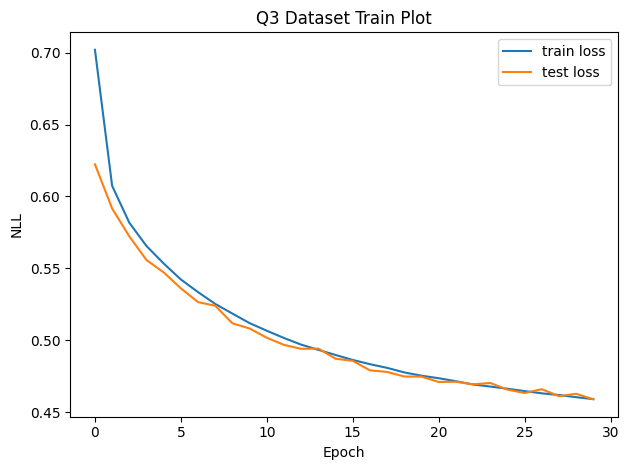

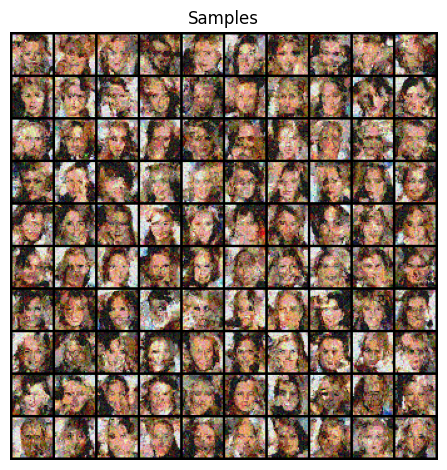

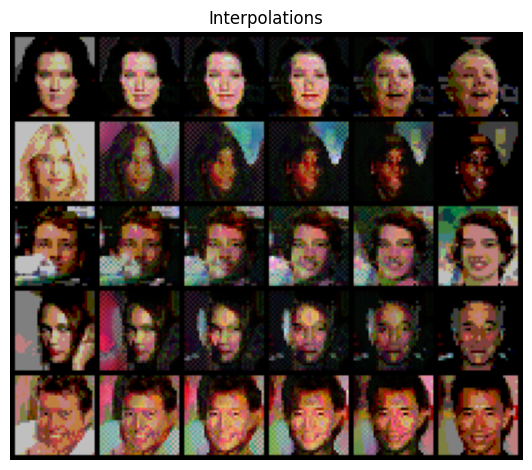

In [ ]:
q3_save_results(q3_a, 'a')

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset.

**Provide the same deliverables as part (a)**

In [ ]:
class RealNVP_BadScheme(RealNVP):
  def __init__(self, device):
    super(RealNVP_BadScheme, self).__init__(device)
    self.device = device
    self.checker_board1 = nn.ModuleList([AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3)])

    self.channels_wise = nn.ModuleList([AffineCouplingWithChannel('A', (12, 16, 16), device),
                                        ActNorm(12),
                                        AffineCouplingWithChannel('A', (12, 16, 16),  device),
                                        ActNorm(12),
                                        AffineCouplingWithChannel('A', (12, 16, 16), device),
                                        ActNorm(12)])

    self.checker_board2 = nn.ModuleList([AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithChannel('A', (3, 32, 32), device),
                                         ActNorm(3),
                                         AffineCouplingWithChannel('B', (3, 32, 32), device),
                                         ActNorm(3)])

In [ ]:
def q3_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  """ YOUR CODE HERE """
  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  model = RealNVP_BadScheme(device).to(device)
  trainer = Trainer(model, device)
  train_losses, val_losses = trainer.train(epochs=30, train_data=train_data, test_data=test_data)
  sampled_imgs = trainer.sample(100)
  interpolations = trainer.interpolate(trainer.test_loader)
  return train_losses, val_losses, sampled_imgs, interpolations

In [ ]:
q3_save_results(q3_b, 'b')

<ipython-input-3-cae9dbba0912>:340: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, imgs in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [1/30], Loss 0.9451248645782471
Step [200/313], Epoch [1/30], Loss 0.8509640097618103
Step [300/313], Epoch [1/30], Loss 0.8133372068405151
Epoch 1, Loss 0.9191, Val Loss 0.8123


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [2/30], Loss 0.7823030352592468
Step [200/313], Epoch [2/30], Loss 0.7877990007400513
Step [300/313], Epoch [2/30], Loss 0.7222510576248169
Epoch 2, Loss 0.7855, Val Loss 0.7738


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [3/30], Loss 0.7142719030380249
Step [200/313], Epoch [3/30], Loss 0.7261247038841248
Step [300/313], Epoch [3/30], Loss 0.7302340865135193
Epoch 3, Loss 0.7363, Val Loss 0.7137


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [4/30], Loss 0.7130769491195679
Step [200/313], Epoch [4/30], Loss 0.7129758596420288
Step [300/313], Epoch [4/30], Loss 0.6941313147544861
Epoch 4, Loss 0.7099, Val Loss 0.6968


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [5/30], Loss 0.7133783102035522
Step [200/313], Epoch [5/30], Loss 0.7080623507499695
Step [300/313], Epoch [5/30], Loss 0.7036992907524109


Epoch 5, Loss 0.6934, Val Loss 0.7136


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [6/30], Loss 0.671123206615448
Step [200/313], Epoch [6/30], Loss 0.6808425188064575
Step [300/313], Epoch [6/30], Loss 0.6707580089569092
Epoch 6, Loss 0.6839, Val Loss 0.6731


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [7/30], Loss 0.7011634111404419
Step [200/313], Epoch [7/30], Loss 0.6654629707336426
Step [300/313], Epoch [7/30], Loss 0.6827079057693481
Epoch 7, Loss 0.6761, Val Loss 0.6674


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [8/30], Loss 0.6760193705558777
Step [200/313], Epoch [8/30], Loss 0.6561485528945923
Step [300/313], Epoch [8/30], Loss 0.6695507764816284
Epoch 8, Loss 0.6720, Val Loss 0.6615


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [9/30], Loss 0.6492559909820557
Step [200/313], Epoch [9/30], Loss 0.6551027894020081
Step [300/313], Epoch [9/30], Loss 0.6518835425376892
Epoch 9, Loss 0.6643, Val Loss 0.6573


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [10/30], Loss 0.6607934236526489
Step [200/313], Epoch [10/30], Loss 0.6403372287750244
Step [300/313], Epoch [10/30], Loss 0.6761621236801147


Epoch 10, Loss 0.6608, Val Loss 0.6604


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [11/30], Loss 0.6440607309341431
Step [200/313], Epoch [11/30], Loss 0.6455861926078796
Step [300/313], Epoch [11/30], Loss 0.6436583399772644
Epoch 11, Loss 0.6537, Val Loss 0.6491


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [12/30], Loss 0.6446596384048462
Step [200/313], Epoch [12/30], Loss 0.6310967206954956
Step [300/313], Epoch [12/30], Loss 0.6519096493721008
Epoch 12, Loss 0.6523, Val Loss 0.6452


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [13/30], Loss 0.6812589168548584
Step [200/313], Epoch [13/30], Loss 0.6248753070831299
Step [300/313], Epoch [13/30], Loss 0.6445232629776001
Epoch 13, Loss 0.6468, Val Loss 0.6466


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [14/30], Loss 0.6505405306816101
Step [200/313], Epoch [14/30], Loss 0.6218277215957642
Step [300/313], Epoch [14/30], Loss 0.623282790184021
Epoch 14, Loss 0.6459, Val Loss 0.6453


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [15/30], Loss 0.6319562792778015
Step [200/313], Epoch [15/30], Loss 0.6319797039031982
Step [300/313], Epoch [15/30], Loss 0.6309570074081421


# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
# model
class SqueezeFlow(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device

  def forward(self, x, inverse=False):
    if not inverse:
      """
        [b, c, h, w] --> [b, c*4, h//2, w//2]
      """
      b, c, h, w = x.shape
      x = x.view(b, c, h//2, 2, w//2, 2)
      x = x.permute(0, 1, 3, 5, 2, 4) # b, c, 2, 2, h//2, w//2
      x = x.contiguous().view(b, c*4, h//2, h//2)
      return x, torch.zeros(1).to(self.device)
    else:
        """
            [b, c*4, h//2, w//2] --> [b, c, h, w]
        """
        b, c, h, w = x.shape
        x = x.view(b, c//4, 2, 2, h, w)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.contiguous().view(b, c//4, h*2, w*2)
        return x


class SplitFlow(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.prior = torch.distributions.normal.Normal(0.0, 1.0)

  def forward(self, x, inverse=False, interpolate=False):
    """
      If interpolate = true, x should be a tuple.
    """
    if not inverse:
      x, z_split = x.chunk(2, dim=1)
      return x, z_split
    else:
      if interpolate:
        x = torch.cat(x, dim=1)
      else:
        z_split = self.prior.sample(x.shape).to(self.device)
        x = torch.cat([x, z_split], dim=1)

      return x


class Block(nn.Module):
  def __init__(self, input_size, device, split=True):
    super().__init__()
    self.input_size = input_size
    self.device = device
    self.split = split

    if self.split:
      self.flow = nn.ModuleList([AffineCouplingWithCheckerBoard('A', input_size, device),
                                ActNorm(input_size[0]),
                                AffineCouplingWithCheckerBoard('B', input_size, device),
                                ActNorm(input_size[0]),
                                AffineCouplingWithCheckerBoard('A', input_size, device),
                                ActNorm(input_size[0]),
                                SqueezeFlow(device),
                                AffineCouplingWithChannel('A', (input_size[0]*4, input_size[1]//2, input_size[2]//2), device),
                                ActNorm(input_size[0]*4),
                                AffineCouplingWithChannel('B', (input_size[0]*4, input_size[1]//2, input_size[2]//2), device),
                                ActNorm(input_size[0]*4),
                                AffineCouplingWithChannel('A', (input_size[0]*4, input_size[1]//2, input_size[2]//2), device),
                                ActNorm(input_size[0]*4)])
      self.split_flow = SplitFlow(device)
    else:
      self.flow = nn.ModuleList([AffineCouplingWithCheckerBoard('A', input_size, device),
                                 ActNorm(input_size[0]),
                                 AffineCouplingWithCheckerBoard('B', input_size, device),
                                 ActNorm(input_size[0]),
                                 SqueezeFlow(device),
                                 AffineCouplingWithCheckerBoard('A', (input_size[0]*4, input_size[1]//2, input_size[2]//2), device),
                                 ActNorm(input_size[0]*4),
                                 AffineCouplingWithCheckerBoard('B', (input_size[0]*4, input_size[1]//2, input_size[2]//2), device),
                                 ActNorm(input_size[0]*4)])

  def forward(self, x, inverse=False, interpolate=False):
    if not inverse:
      sum_log_det = torch.zeros(x.shape[0]).to(self.device)    # [batch]
      for f in self.flow:
        x, log_det = f.forward(x)
        sum_log_det += log_det

      if self.split:
        x, z_split = self.split_flow.forward(x)
        return x, sum_log_det, z_split    # x: [b, c, h, w] -> [b, c*2, h//2, w//2]
      return x, sum_log_det     # x: [b, c, h, w] -> [b, c*4, h//2, w//2]
    else:
      if self.split:
        x = self.split_flow.forward(x, inverse=True, interpolate=interpolate)
      for f in reversed(self.flow):
        x = f.forward(x, inverse=True)
      return x


class MultiScale_RealNVP(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.input_size = (3, 32, 32)
    self.device = device
    self.block1 = Block((3, 32, 32), device, split=True)
    self.block2 = Block((6, 16, 16), device, split=True)
    self.block3 = Block((12, 8, 8), device, split=False)
    self.squeeze = SqueezeFlow(device)
    self.last_z_split_shape = None

  def forward(self, x, inverse=False, interpolate=False):
    if not inverse:
      sum_log_det = torch.zeros(x.shape[0]).to(self.device)  # [b]
      z_splits = []

      x, log_det, z_split = self.block1.forward(x)
      sum_log_det += log_det
      z_splits.append(z_split)  # [b, 6, 16, 16]

      x, log_det, z_split = self.block2.forward(x)
      sum_log_det += log_det
      z_splits.append(z_split) # [b, 12, 8, 8]

      z_split, log_det = self.block3.forward(x)
      sum_log_det += log_det
      z_splits.append(z_split) # [b, 48, 4, 4]
      self.last_z_split_shape = z_split.shape[1:]

      x = self.get_z(z_splits)
      return x, sum_log_det
    else:
      if interpolate:
        z_splits = self.get_z_splits(x)
        x = self.block3.forward(z_splits.pop(-1), inverse=True)
        print('oke')
        x = self.block2.forward((x, z_splits.pop(-1)), inverse=True, interpolate=True)
        x = self.block1.forward((x, z_splits.pop(-1)), inverse=True, interpolate=True)
      else:
        x = self.block3.forward(x, inverse=True)
        x = self.block2.forward(x, inverse=True)
        x = self.block1.forward(x, inverse=True)
      return x


  def get_z(self, z_splits):
    z = self.squeeze(z_splits[-1], inverse=True)
    for z_split in z_splits[-2::-1]:
      z = torch.cat([z, z_split], dim=1)
      z = self.squeeze(z, inverse=True)
    return z


  def get_z_splits(self, z):
    z_splits = []
    for i in range(2): # number of blocks -1 = 2
      z, _ = self.squeeze(z)
      z, z_split = z.chunk(2, 1)
      z_splits.append(z_split)

    z_split, _ = self.squeeze(z)
    z_splits.append(z_split)
    return z_splits


  def log_prob(self, x):
    z, sum_log_det = self.forward(x)
    log_prob = torch.distributions.Normal(0., 1.).log_prob(z).sum(dim=[1, 2, 3]) + sum_log_det  # batch
    return log_prob

  def nll(self, x):
    return - self.log_prob(x).mean()

  def sample(self, n):
    with torch.no_grad():
      z = torch.distributions.Normal(0., 1.).sample((n, *self.last_z_split_shape)).to(self.device)
      x = self.forward(z, inverse=True)
      return x #  tensor: n, channels, height, width


In [ ]:
class Trainer_(Trainer):
  def __init__(self, model, device, lr=5e-4, weight_decay=1e-5):
    super(Trainer_, self).__init__(model, device, lr=lr, weight_decay=weight_decay)

  def interpolate(self, loader):
    self.model.eval()
    indices = [10, 11, 20, 21, 30, 31, 40, 41, 50, 51]
    with torch.no_grad():
      real_imgs = next(iter(loader))[indices].to(self.device).float()
      logit_real_imgs, _ = self.preprocess(real_imgs, dequantize=False)
      z, _ = self.model.forward(logit_real_imgs)

      latent_values = []
      for i in range(0, z.shape[0], 2):
        z0 = z[i, :, :, :]
        z1 = z[i+1, :, :, :]
        latent_values.append(z0)
        for j in range(1, 5):
          latent_values.append(z0 + j*(z1-z0)/5.0)
        latent_values.append(z1)

      latent_values = torch.stack(latent_values, dim = 0)
      logit_imgs = self.model.forward(latent_values, inverse=True, interpolate=True)
      interpolations = self.preprocess(logit_imgs, inverse=True)
      interpolations = interpolations.cpu()
      interpolations = interpolations.numpy()
      interpolations = np.transpose(interpolations, axes = [0, 2, 3, 1])
      return interpolations # np_array: n, height, width, channels

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  """ YOUR CODE HERE """
  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  model = MultiScale_RealNVP(device).to(device)
  trainer = Trainer_(model, device)
  train_losses, val_losses = trainer.train(epochs=30, train_data=train_data, test_data=test_data)
  sampled_imgs = trainer.sample(100)
  interpolations = trainer.interpolate(trainer.test_loader)
  return train_losses, val_losses, sampled_imgs, interpolations

<ipython-input-3-d345f67a6c14>:268: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, imgs in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [1/30], Loss 0.672713041305542
Step [200/313], Epoch [1/30], Loss 0.6050522327423096
Step [300/313], Epoch [1/30], Loss 0.6044459342956543
Epoch 1, Loss 0.6667, Val Loss 0.5998


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [2/30], Loss 0.5863593816757202
Step [200/313], Epoch [2/30], Loss 0.5723403692245483
Step [300/313], Epoch [2/30], Loss 0.5823670625686646
Epoch 2, Loss 0.5837, Val Loss 0.5655


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [3/30], Loss 0.5445896983146667
Step [200/313], Epoch [3/30], Loss 0.5498376488685608
Step [300/313], Epoch [3/30], Loss 0.557500958442688
Epoch 3, Loss 0.5562, Val Loss 0.5442


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [4/30], Loss 0.5235223174095154
Step [200/313], Epoch [4/30], Loss 0.523341953754425
Step [300/313], Epoch [4/30], Loss 0.5196972489356995
Epoch 4, Loss 0.5387, Val Loss 0.5325


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [5/30], Loss 0.5224349498748779
Step [200/313], Epoch [5/30], Loss 0.5143632292747498
Step [300/313], Epoch [5/30], Loss 0.5102765560150146


Epoch 5, Loss 0.5258, Val Loss 0.5193


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [6/30], Loss 0.5158795118331909
Step [200/313], Epoch [6/30], Loss 0.5081376433372498
Step [300/313], Epoch [6/30], Loss 0.5294146537780762
Epoch 6, Loss 0.5163, Val Loss 0.5110


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [7/30], Loss 0.5212929248809814
Step [200/313], Epoch [7/30], Loss 0.486743301153183
Step [300/313], Epoch [7/30], Loss 0.5155926942825317
Epoch 7, Loss 0.5087, Val Loss 0.5076


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [8/30], Loss 0.5088256597518921
Step [200/313], Epoch [8/30], Loss 0.4991331994533539
Step [300/313], Epoch [8/30], Loss 0.4886137843132019
Epoch 8, Loss 0.5026, Val Loss 0.4986


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [9/30], Loss 0.4933769702911377
Step [200/313], Epoch [9/30], Loss 0.4946194589138031
Step [300/313], Epoch [9/30], Loss 0.4934106767177582
Epoch 9, Loss 0.4976, Val Loss 0.4943


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [10/30], Loss 0.49326008558273315
Step [200/313], Epoch [10/30], Loss 0.5053991675376892
Step [300/313], Epoch [10/30], Loss 0.5053310394287109


Epoch 10, Loss 0.4931, Val Loss 0.4901


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [11/30], Loss 0.5049893260002136
Step [200/313], Epoch [11/30], Loss 0.5106329321861267
Step [300/313], Epoch [11/30], Loss 0.4695685803890228
Epoch 11, Loss 0.4890, Val Loss 0.4859


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [12/30], Loss 0.4606421887874603
Step [200/313], Epoch [12/30], Loss 0.47306570410728455
Step [300/313], Epoch [12/30], Loss 0.47878527641296387
Epoch 12, Loss 0.4856, Val Loss 0.4847


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [13/30], Loss 0.4834417700767517
Step [200/313], Epoch [13/30], Loss 0.4908476769924164
Step [300/313], Epoch [13/30], Loss 0.48770126700401306
Epoch 13, Loss 0.4829, Val Loss 0.4821


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [14/30], Loss 0.4730447232723236
Step [200/313], Epoch [14/30], Loss 0.4943627715110779
Step [300/313], Epoch [14/30], Loss 0.46354031562805176
Epoch 14, Loss 0.4802, Val Loss 0.4771


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [15/30], Loss 0.4695243835449219
Step [200/313], Epoch [15/30], Loss 0.48621511459350586
Step [300/313], Epoch [15/30], Loss 0.4852689504623413


Epoch 15, Loss 0.4770, Val Loss 0.4793


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [16/30], Loss 0.45394301414489746
Step [200/313], Epoch [16/30], Loss 0.4600331485271454
Step [300/313], Epoch [16/30], Loss 0.4715874195098877
Epoch 16, Loss 0.4748, Val Loss 0.4744


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [17/30], Loss 0.4668143689632416
Step [200/313], Epoch [17/30], Loss 0.47463497519493103
Step [300/313], Epoch [17/30], Loss 0.48299479484558105
Epoch 17, Loss 0.4725, Val Loss 0.4733


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [18/30], Loss 0.47894686460494995
Step [200/313], Epoch [18/30], Loss 0.48379164934158325
Step [300/313], Epoch [18/30], Loss 0.47051477432250977
Epoch 18, Loss 0.4705, Val Loss 0.4707


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [19/30], Loss 0.4651913046836853
Step [200/313], Epoch [19/30], Loss 0.4826314449310303
Step [300/313], Epoch [19/30], Loss 0.4703548848628998
Epoch 19, Loss 0.4686, Val Loss 0.4677


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [20/30], Loss 0.46985459327697754
Step [200/313], Epoch [20/30], Loss 0.4776857793331146
Step [300/313], Epoch [20/30], Loss 0.46657294034957886


Epoch 20, Loss 0.4672, Val Loss 0.4666


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [21/30], Loss 0.4784628748893738
Step [200/313], Epoch [21/30], Loss 0.45919761061668396
Step [300/313], Epoch [21/30], Loss 0.45495665073394775
Epoch 21, Loss 0.4649, Val Loss 0.4641


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [22/30], Loss 0.45294782519340515
Step [200/313], Epoch [22/30], Loss 0.4881840944290161
Step [300/313], Epoch [22/30], Loss 0.47769278287887573
Epoch 22, Loss 0.4636, Val Loss 0.4624


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [23/30], Loss 0.46097689867019653
Step [200/313], Epoch [23/30], Loss 0.4547727108001709
Step [300/313], Epoch [23/30], Loss 0.45106786489486694
Epoch 23, Loss 0.4624, Val Loss 0.4616


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [24/30], Loss 0.47170490026474
Step [200/313], Epoch [24/30], Loss 0.4778335690498352
Step [300/313], Epoch [24/30], Loss 0.45575159788131714
Epoch 24, Loss 0.4604, Val Loss 0.4632


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [25/30], Loss 0.47127217054367065
Step [200/313], Epoch [25/30], Loss 0.46152815222740173
Step [300/313], Epoch [25/30], Loss 0.4620886743068695


Epoch 25, Loss 0.4596, Val Loss 0.4581


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [26/30], Loss 0.45973071455955505
Step [200/313], Epoch [26/30], Loss 0.46295541524887085
Step [300/313], Epoch [26/30], Loss 0.4674644470214844
Epoch 26, Loss 0.4586, Val Loss 0.4589


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [27/30], Loss 0.4714199900627136
Step [200/313], Epoch [27/30], Loss 0.45910948514938354
Step [300/313], Epoch [27/30], Loss 0.4558046758174896
Epoch 27, Loss 0.4571, Val Loss 0.4577


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [28/30], Loss 0.458950936794281
Step [200/313], Epoch [28/30], Loss 0.46215033531188965
Step [300/313], Epoch [28/30], Loss 0.447475403547287
Epoch 28, Loss 0.4559, Val Loss 0.4561


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [29/30], Loss 0.4604467749595642
Step [200/313], Epoch [29/30], Loss 0.44155001640319824
Step [300/313], Epoch [29/30], Loss 0.4597967565059662
Epoch 29, Loss 0.4548, Val Loss 0.4556


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [30/30], Loss 0.4464755654335022
Step [200/313], Epoch [30/30], Loss 0.45034167170524597
Step [300/313], Epoch [30/30], Loss 0.4529341161251068


Epoch 30, Loss 0.4538, Val Loss 0.4525
Total training time: 6803.62 seconds
oke
Final Test Loss: 0.4525


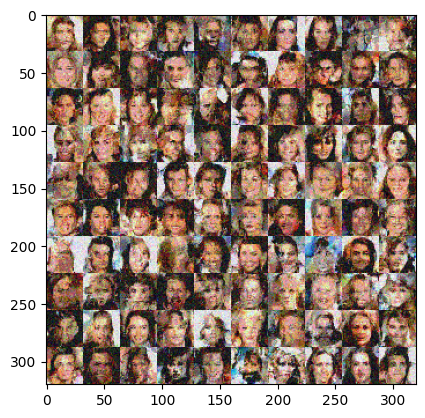

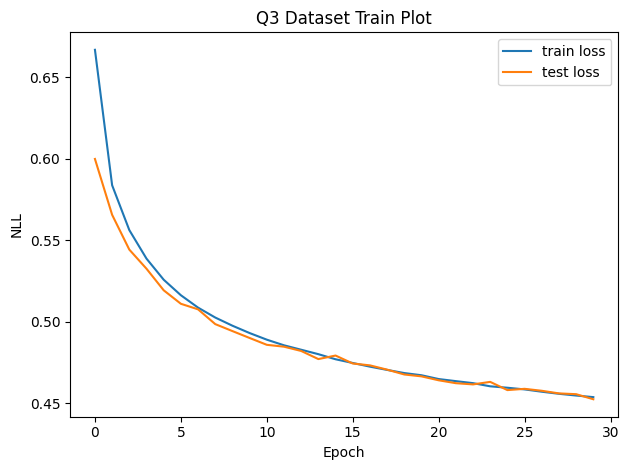

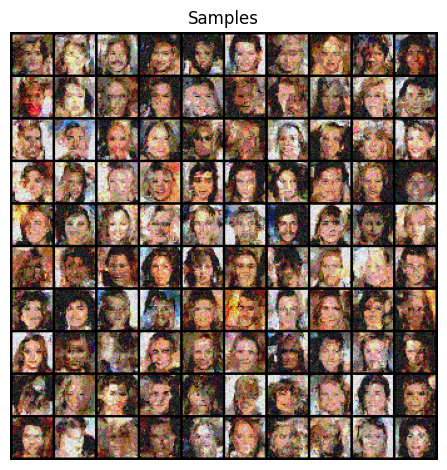

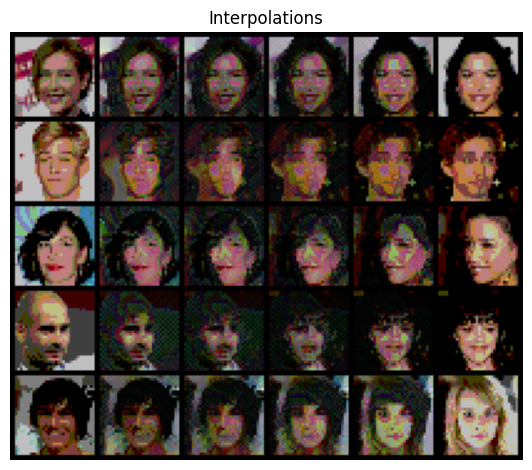

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
# model
import scipy

class InvConv1x1LU(nn.Module):
  def __init__(self, channels, device):
    super().__init__()
    self.device = device
    weight = np.random.rand(channels, channels)
    q, _ = scipy.linalg.qr(weight)
    p, l , u = scipy.linalg.lu(q.astype(np.float32))
    s = np.diag(u)
    u = np.triu(u, k=1)
    mask_u = np.triu(np.ones_like(u), k=1)
    mask_l = mask_u.T

    p = torch.from_numpy(p).to(device).float()
    l = torch.from_numpy(l).to(device).float()
    u = torch.from_numpy(u).to(device).float()
    s = torch.from_numpy(s).to(device).float()
    self.register_buffer('p', p)
    self.register_buffer('mask_u', torch.from_numpy(mask_u).to(device).float())
    self.register_buffer('mask_l', torch.from_numpy(mask_l).to(device).float())
    self.register_buffer('s_sign', torch.sign(s))

    self.l = nn.Parameter(l)
    self.u = nn.Parameter(u)
    self.log_abs_s = nn.Parameter(torch.log(torch.abs(s)))

  def get_weight(self):
    weight = self.p @ (self.l*self.mask_l + torch.eye(self.l.shape[0]).to(self.device)) @ (self.u*self.mask_u + torch.diag(self.s_sign*torch.exp(self.log_abs_s)))
    return weight   # channels, channels

  def forward(self, x, inverse=False):
    if not inverse:
      b, _, h, w = x.shape
      weight = self.get_weight().unsqueeze(2).unsqueeze(3)   # channels, channels, 1, 1
      log_det = h*w*torch.sum(self.log_abs_s) # batch
      x = F.conv2d(x, weight)   # batch, channels, height, width
      return x, log_det

    else:
      return F.conv2d(x, self.get_weight().inverse().unsqueeze(2).unsqueeze(3))


def Squeeze(x):
  """
    [b, c, h, w] --> [b, c*4, h//2, w//2]
  """
  b, c, h, w = x.shape
  x = x.view(b, c, h//2, 2, w//2, 2)
  x = x.permute(0, 1, 3, 5, 2, 4) # b, c, 2, 2, h//2, w//2
  x = x.contiguous().view(b, c*4, h//2, h//2)
  return x

def Unsqueeze(x):
  """
      [b, c*4, h//2, w//2] --> [b, c, h, w]
  """
  b, c, h, w = x.shape
  x = x.view(b, c//4, 2, 2, h, w)
  x = x.permute(0, 1, 4, 2, 5, 3)
  x = x.contiguous().view(b, c//4, h*2, w*2)
  return x


class Flow(nn.Module):
  def __init__(self, mask_type, device, coupling_type='checker_board'):
    super().__init__()
    assert coupling_type in ['checker_board', 'channel_wise']
    self.device = device
    self.coupling_type = coupling_type
    if coupling_type == 'checker_board':
      self.flow = nn.ModuleList([ActNorm(3),
                                InvConv1x1LU(3, device),
                                AffineCouplingWithCheckerBoard(mask_type, device)])

    if coupling_type == 'channel_wise':
      self.flow = nn.ModuleList([ActNorm(12),
                                 InvConv1x1LU(12, device),
                                 AffineCouplingWithChannel(mask_type, device)])

  def forward(self, x, inverse=False):
    """
      Input: x      # batch, channels, height, width
    """
    if not inverse:
      batch = x.shape[0]
      z = x
      sum_log_det = torch.zeros(batch).to(self.device)
      z = Squeeze(z) if self.coupling_type=='channel_wise' else z
      for f in self.flow:
        z, log_det = f.forward(z)
        sum_log_det += log_det
      z = Unsqueeze(z) if self.coupling_type=='channel_wise' else z

      return z, sum_log_det  # z: [batch, channels, height, width]; sum_log_det: [batch]

    else:
      z = x
      z = Squeeze(z) if self.coupling_type=='channel_wise' else z
      for f in reversed(self.flow):
        z = f.forward(z, inverse=True)
      z = Unsqueeze(z) if self.coupling_type=='channel_wise' else z
      return z

class Flow_with_InvConv1x1(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.input_shape = (3, 32, 32)
    self.flows = nn.ModuleList([Flow('A', device, 'checker_board'),
                                Flow('B', device, 'checker_board'),
                                Flow('A', device, 'checker_board'),
                                Flow('A', device, 'channel_wise'),
                                Flow('B', device, 'channel_wise'),
                                Flow('A', device, 'checker_board'),
                                Flow('B', device, 'checker_board')])


  def forward(self, x, inverse=False):
    if not inverse:
      batch = x.shape[0]
      z = x
      sum_log_det = torch.zeros(batch).to(self.device)
      for f in self.flows:
        z, log_det = f.forward(z)
        sum_log_det += log_det
      return z, sum_log_det

    else:
      z = x
      for f in reversed(self.flows):
        z = f.forward(z, inverse=True)
      return z

  def log_prob(self, x):
    z, sum_log_det = self.forward(x)
    log_prob = torch.distributions.Normal(0., 1.).log_prob(z).sum(dim=[1, 2, 3]) + sum_log_det  # batch
    return log_prob

  def nll(self, x):
    return - self.log_prob(x).mean()

  def sample(self, n):
    with torch.no_grad():
      z = torch.distributions.Normal(0., 1.).sample((n, *self.input_shape)).to(self.device)
      x = self.forward(z, inverse=True)
      return x #  tensor: n, channels, height, width

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """

  """ YOUR CODE HERE """
  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
  model = Flow_with_InvConv1x1(device).to(device)
  trainer = Trainer(model, device)
  train_losses, val_losses = trainer.train(epochs=30, train_data=train_data, test_data=test_data)
  sampled_imgs = trainer.sample(100)
  interpolations = trainer.interpolate(trainer.test_loader)
  return train_losses, val_losses, sampled_imgs, interpolations

<ipython-input-5-630ba04abf42>:20: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  s = torch.from_numpy(s).to(device).float()
<ipython-input-4-9c2451251742>:301: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, imgs in enumerate(tqdm_notebook(self.train_loader, desc='Batch', leave=False)):


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [1/30], Loss 0.682375431060791
Step [200/313], Epoch [1/30], Loss 0.642305314540863
Step [300/313], Epoch [1/30], Loss 0.6278901100158691
Epoch 1, Loss 0.6689, Val Loss 0.6204


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [2/30], Loss 0.6118931174278259
Step [200/313], Epoch [2/30], Loss 0.5956940650939941
Step [300/313], Epoch [2/30], Loss 0.6010898947715759
Epoch 2, Loss 0.6114, Val Loss 0.6020


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [3/30], Loss 0.5754941701889038
Step [200/313], Epoch [3/30], Loss 0.594673752784729
Step [300/313], Epoch [3/30], Loss 0.574906587600708
Epoch 3, Loss 0.5925, Val Loss 0.5849


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [4/30], Loss 0.5898438096046448
Step [200/313], Epoch [4/30], Loss 0.5762717127799988
Step [300/313], Epoch [4/30], Loss 0.570103645324707
Epoch 4, Loss 0.5788, Val Loss 0.5707


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [5/30], Loss 0.5695764422416687
Step [200/313], Epoch [5/30], Loss 0.5710391402244568
Step [300/313], Epoch [5/30], Loss 0.5649443864822388


Epoch 5, Loss 0.5683, Val Loss 0.5591


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [6/30], Loss 0.5474393963813782
Step [200/313], Epoch [6/30], Loss 0.5606784820556641
Step [300/313], Epoch [6/30], Loss 0.5468600392341614
Epoch 6, Loss 0.5581, Val Loss 0.5505


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [7/30], Loss 0.54928058385849
Step [200/313], Epoch [7/30], Loss 0.5521886348724365
Step [300/313], Epoch [7/30], Loss 0.5544210076332092
Epoch 7, Loss 0.5492, Val Loss 0.5423


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [8/30], Loss 0.5573284029960632
Step [200/313], Epoch [8/30], Loss 0.5386613607406616
Step [300/313], Epoch [8/30], Loss 0.5307726860046387
Epoch 8, Loss 0.5410, Val Loss 0.5343


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [9/30], Loss 0.5275153517723083
Step [200/313], Epoch [9/30], Loss 0.5442792773246765
Step [300/313], Epoch [9/30], Loss 0.526237964630127
Epoch 9, Loss 0.5333, Val Loss 0.5355


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [10/30], Loss 0.5457078814506531
Step [200/313], Epoch [10/30], Loss 0.5418615341186523
Step [300/313], Epoch [10/30], Loss 0.5224588513374329


Epoch 10, Loss 0.5269, Val Loss 0.5225


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [11/30], Loss 0.5136896371841431
Step [200/313], Epoch [11/30], Loss 0.5255641341209412
Step [300/313], Epoch [11/30], Loss 0.5376637578010559
Epoch 11, Loss 0.5209, Val Loss 0.5174


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [12/30], Loss 0.511374831199646
Step [200/313], Epoch [12/30], Loss 0.5100246667861938
Step [300/313], Epoch [12/30], Loss 0.5385361313819885
Epoch 12, Loss 0.5158, Val Loss 0.5127


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [13/30], Loss 0.5191671252250671
Step [200/313], Epoch [13/30], Loss 0.5154106616973877
Step [300/313], Epoch [13/30], Loss 0.5114753246307373
Epoch 13, Loss 0.5108, Val Loss 0.5059


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [14/30], Loss 0.49405044317245483
Step [200/313], Epoch [14/30], Loss 0.5012145042419434
Step [300/313], Epoch [14/30], Loss 0.5059939026832581
Epoch 14, Loss 0.5075, Val Loss 0.5019


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [15/30], Loss 0.48035746812820435
Step [200/313], Epoch [15/30], Loss 0.510709285736084
Step [300/313], Epoch [15/30], Loss 0.5017616748809814


Epoch 15, Loss 0.5033, Val Loss 0.5002


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [16/30], Loss 0.5141778588294983
Step [200/313], Epoch [16/30], Loss 0.5192393660545349
Step [300/313], Epoch [16/30], Loss 0.5017222762107849
Epoch 16, Loss 0.5006, Val Loss 0.4978


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [17/30], Loss 0.5071655511856079
Step [200/313], Epoch [17/30], Loss 0.5034452676773071
Step [300/313], Epoch [17/30], Loss 0.5066521167755127
Epoch 17, Loss 0.4977, Val Loss 0.4943


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [18/30], Loss 0.5013245344161987
Step [200/313], Epoch [18/30], Loss 0.498089998960495
Step [300/313], Epoch [18/30], Loss 0.49886882305145264
Epoch 18, Loss 0.4951, Val Loss 0.4914


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [19/30], Loss 0.4863491952419281
Step [200/313], Epoch [19/30], Loss 0.4915538430213928
Step [300/313], Epoch [19/30], Loss 0.4885222911834717
Epoch 19, Loss 0.4930, Val Loss 0.4890


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [20/30], Loss 0.499769389629364
Step [200/313], Epoch [20/30], Loss 0.4991401433944702
Step [300/313], Epoch [20/30], Loss 0.48802781105041504


Epoch 20, Loss 0.4907, Val Loss 0.4893


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [21/30], Loss 0.48955267667770386
Step [200/313], Epoch [21/30], Loss 0.48996567726135254
Step [300/313], Epoch [21/30], Loss 0.4863409399986267
Epoch 21, Loss 0.4892, Val Loss 0.4849


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [22/30], Loss 0.4820888042449951
Step [200/313], Epoch [22/30], Loss 0.49113893508911133
Step [300/313], Epoch [22/30], Loss 0.481912225484848
Epoch 22, Loss 0.4872, Val Loss 0.4849


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [23/30], Loss 0.4700748324394226
Step [200/313], Epoch [23/30], Loss 0.4929268956184387
Step [300/313], Epoch [23/30], Loss 0.49393606185913086
Epoch 23, Loss 0.4853, Val Loss 0.4826


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [24/30], Loss 0.5065504312515259
Step [200/313], Epoch [24/30], Loss 0.4631769359111786
Step [300/313], Epoch [24/30], Loss 0.4813354015350342
Epoch 24, Loss 0.4838, Val Loss 0.4815


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [25/30], Loss 0.4971805512905121
Step [200/313], Epoch [25/30], Loss 0.46099066734313965
Step [300/313], Epoch [25/30], Loss 0.4978559613227844


Epoch 25, Loss 0.4826, Val Loss 0.4803


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [26/30], Loss 0.47800421714782715
Step [200/313], Epoch [26/30], Loss 0.48399996757507324
Step [300/313], Epoch [26/30], Loss 0.4863351583480835
Epoch 26, Loss 0.4809, Val Loss 0.4804


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [27/30], Loss 0.48344939947128296
Step [200/313], Epoch [27/30], Loss 0.46197646856307983
Step [300/313], Epoch [27/30], Loss 0.4803895950317383
Epoch 27, Loss 0.4798, Val Loss 0.4787


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [28/30], Loss 0.4909019470214844
Step [200/313], Epoch [28/30], Loss 0.500771164894104
Step [300/313], Epoch [28/30], Loss 0.4804534912109375
Epoch 28, Loss 0.4784, Val Loss 0.4762


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [29/30], Loss 0.4685681462287903
Step [200/313], Epoch [29/30], Loss 0.47973453998565674
Step [300/313], Epoch [29/30], Loss 0.49566933512687683
Epoch 29, Loss 0.4774, Val Loss 0.4782


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Step [100/313], Epoch [30/30], Loss 0.48505350947380066
Step [200/313], Epoch [30/30], Loss 0.4746459126472473
Step [300/313], Epoch [30/30], Loss 0.46608075499534607


Epoch 30, Loss 0.4762, Val Loss 0.4758
Final Test Loss: 0.4758


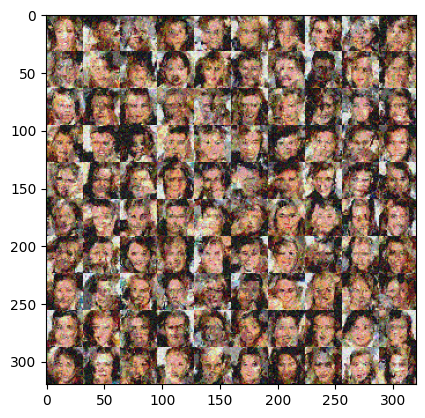

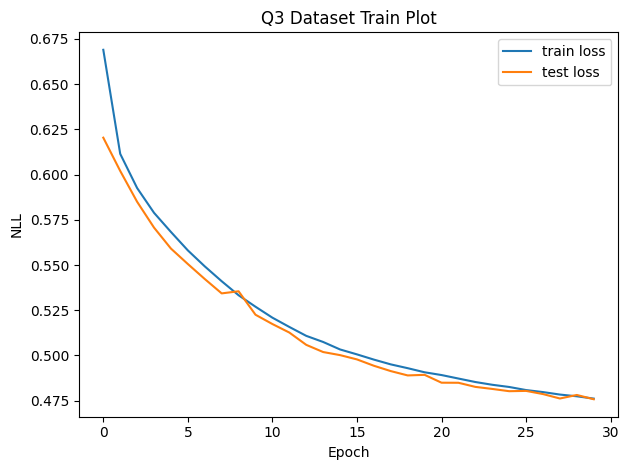

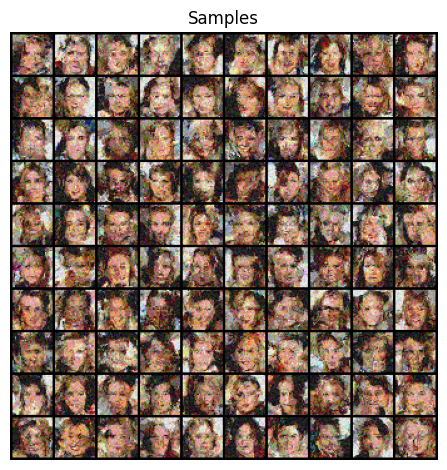

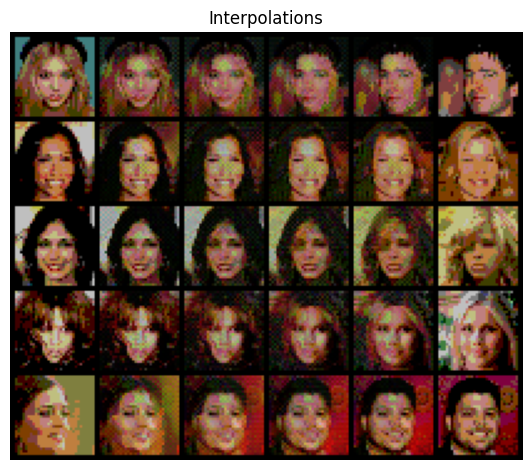

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)